# Algorytmy tekstowe - laboraorium 2

Importowanie bibliotek i potrzebnych struktur:

In [29]:
from queue import PriorityQueue
from collections import Counter
import random
import os
import pandas as pd
import time
import matplotlib.pyplot as plt

# 1. Zadanie polega na implementacji dwóch algorytmów kompresji:

### 1. statycznego algorytmu Huffmana (2 p)

In [2]:
class Node1:
    def __init__(self, frequency, sign=None):
        self.frequency = frequency
        self.sign = sign
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency


def build_tree_static(signs):
    frequencies = Counter(signs)
    nodes = [Node1(frequencies[sign], sign) for sign in frequencies]
    pq = PriorityQueue()
    root = None
    
    for node in nodes:
        pq.put(node)
    
    while True:
        left = pq.get()
        right = pq.get()
        parent = Node1(left.frequency + right.frequency)
        parent.left, parent.right = left, right
        pq.put(parent)
        
        if pq.qsize() == 1: # root
            root = pq.get()
            break

    return root


def build_code_table(node, codes = {}, code = ""):
    if node.sign is not None:
        codes[node.sign] = code
        
    if node.left is not None:
        build_code_table(node.left, codes, code + "0")
    if node.right is not None:
        build_code_table(node.right, codes, code + "1")

    return codes

def static_huffman_encode(data):
    root = build_tree_static(data)
    codes = build_code_table(root)
    
    result = ""
    
    for sign in data:
        result += codes[sign]
        
    return result, root

def static_huffman_decode(encoded_data, root):
    decoded_data = ""
    node = root

    for bit in encoded_data:
        if bit == "1": node = node.right
        else: node = node.left

        if node.sign is not None:
            decoded_data += node.sign
            node = root

    return decoded_data

Test działnia:

In [3]:
data = "abracadabra"
result, root = static_huffman_encode(data)
print("Encoded data: " + result)
print("Is implemented correctly?: " + str(data == static_huffman_decode(result, root)))

Encoded data: 01111100100010101111100
Is implemented correctly?: True


### 2. dynamicznego algorytmu Huffmana (3 p)

In [8]:
class Node2:
    def __init__(self, sign=None, weight=0, parent=None, left=None, right=None):
        self.sign = sign
        self.weight = weight
        self.parent = parent
        self.left = left
        self.right = right
        
    def __lt__(self, other):
        return self.weight < other.weight

def update_tree(node): # przechodzenie po drzewie metoda bottom-up i naprawianie drzewa
    parent = node.parent
    
    if parent is None: # mamy korzeń - koniec rekurencji, nie trzeba już nic poprawiać
        return
    
    nodes = [parent.left, parent.right]
    
    if nodes[0].weight > nodes[1].weight or nodes[0] is not node:
        nodes[0], nodes[1] = nodes[1], nodes[0]
        
    update_tree(parent)

def get_code(node):
    code = []
    while node.parent is not None:
        if node == node.parent.left:
            code.append('0')
        else:
            code.append('1')
        node = node.parent
    return list(reversed(code))

def build_tree_dynamic(data): # tworzenie drzewa Huffmana, łączy dwa najmniejsze węzły w kazdym kroku 
    sign_nodes = {}
    
    for sign in data: # inicjalizacja każdego znaku jako Node w slowniku node'ów
        sign = str(sign)
        sign_nodes[sign] = sign_nodes.get(sign, Node2(sign=sign,weight= 0))
        sign_nodes[sign].weight += 1

    leaves = list(sign_nodes.values())
    
    while len(leaves) > 1:
        leaves.sort(key=lambda n: (n.weight, id(n)))
        left, right = leaves.pop(0), leaves.pop(0)
        parent = Node2(None, left.weight + right.weight, None, left, right)
        left.parent = right.parent = parent
        leaves.append(parent)

    
    return leaves[0], sign_nodes

## kodowanie i dekodowanie
def dynamic_huffman_encode(data):
    root, sign_nodes = build_tree_dynamic(data)
    bits = []
    for sign in data:
        bits.extend(get_code(sign_nodes[sign]))
    return ''.join(bits), root

def dynamic_huffman_decode(bits, root):
    current = root
    signs = []
    for bit in bits:
        if bit == '0':
            current = current.left
        else:
            current = current.right
        if current.sign is not None:
            signs.append(current.sign)
            current = root
    return ''.join(signs)

Test działania:

In [9]:
data = "abracadabra"
result, root = dynamic_huffman_encode(data)
print("Encoded data: " + result)
print("Is implemented correctly?: " + str(data == dynamic_huffman_decode(result, root)))

Encoded data: 01111001100011010111100
Is implemented correctly?: True


# Dla każdego z algorytmów należy wykonać następujące zadania:

#### Opracować format pliku przechowującego dane. Zwróć uwagę na dwie kwestie:

<ol>
    <li> Liczba bitów wynikowego pliku nie musi być podzielna przez 8, ale z dysku zawsze odczytujemy pełne bajty, dlatego ważne jest, aby jakoś rozwiązać ten problem. W przeciwnym razie po dekompresji można uzyskać nadmiarowe dane. </li>
    <li> Plik wynikowy musi być binarny, tzn. rozwiązanie nie może zakładać, że w pliku tym zapisywane są 0 i 1 jako znaki ASCII. </li>
</ol>

#### Pomysł:

Na początku pliku zapisywana jest wartość paddingu, która określa liczbę bitów na końcu zakodowanych danych, które należy zignorować przy dekompresji (aby dlugosc tekstu byla podzielna przez 8 dodano na koniec w brakujące miejsca 0). Następnie każde 8 bitów zakodowanych danych są zapisywane jako pojedynczy bajt w pliku binarnym. 

# Zaimplementować algorytm kompresji i dekompresji danych dla tego formatu pliku.

#### Huffman statyczny:

In [10]:
def static_huffman_encode_file(data, output_file):
    root = build_tree_static(data)
    codes = build_code_table(root)
    
    encoded_data = ""
    
    for sign in data:
        encoded_data += codes[sign]
    
    # Obliczam, ile zer jest potrzebnych na końcu, aby uzupełnić ostatni bajt.
    padding = 8 - (len(encoded_data) % 8)
    encoded_data += padding * "0"
    

    with open(output_file, "wb") as file:
        # na początku pliku jest wpisana ilosc zer do zignorowania
        file.write(bytes([padding]))
        
        # wpisywanie zakodowanych znakow do pliku
        for i in range(0, len(encoded_data), 8):
            byte = encoded_data[i:i+8]
            file.write(bytes([int(byte, 2)]))
    
    return root, output_file


def static_huffman_decode_file(input_file, root):

    with open(input_file, "rb") as file:
        # wczytanie ilosci zer do zignorowania
        padding = file.read(1)[0]
        
        # wczytywanie kodow z pliku 
        encoded_data = ""
        byte = file.read(1)
        while byte:
            encoded_data += bin(byte[0])[2:].zfill(8)
            byte = file.read(1)
    
    # usuwanie dodanych zer z konca
    encoded_data = encoded_data[:-padding]
    
    decoded_data = ""
    node = root
    
    for bit in encoded_data:
        if bit == "1": node = node.right
        else: node = node.left

        if node.sign is not None:
            decoded_data += node.sign
            node = root

    return decoded_data

Testowanie:

In [11]:
data = "aabbbcdddde"
encoded_file = "encoded.bin"
decoded_file = "decoded.txt"

# kodowanie
root, _ = static_huffman_encode_file(data, encoded_file)

# dekodowanie
decoded_data = static_huffman_decode_file(encoded_file, root)

with open(decoded_file, "w") as file:
    file.write(decoded_data)

# sprawdzenie poprawności
with open(decoded_file, "r") as file:
    if file.read() == data:
        print("Implemented correctly")

Implemented correctly


#### Huffman dynamiczny:

In [12]:
def dynamic_huffman_encode_file(data, output_file):
    root, codes = build_tree_dynamic(data)
    
    encoded_data = ""
    
    for sign in data:
        encoded_data += codes[sign].sign
    
    bits = []
    for i in encoded_data:
        bits.extend(get_code(codes[i]))
        
    encoded_data = ''.join(bits)
    
    # Obliczam, ile zer jest potrzebnych na końcu, aby uzupełnić ostatni bajt.
    padding = 8 - (len(encoded_data) % 8)
    encoded_data += padding * "0"
    

    with open(output_file, "wb") as file:
        # na początku pliku jest wpisana ilosc zer do zignorowania
        file.write(bytes([padding]))
        
        # wpisywanie zakodowanych znakow do pliku
        for i in range(0, len(encoded_data), 8):
            byte = encoded_data[i:i+8]
            file.write(bytes([int(byte, 2)]))
    
    return root, output_file

def dynamic_huffman_decode_file(input_file, root):

    with open(input_file, "rb") as file:
        # wczytanie ilosci zer do zignorowania
        padding = file.read(1)[0]
        
        # wczytywanie kodow z pliku 
        encoded_data = ""
        byte = file.read(1)
        while byte:
            encoded_data += bin(byte[0])[2:].zfill(8)
            byte = file.read(1)
    
    # usuwanie dodanych zer z konca
    encoded_data = encoded_data[:-padding]
    
    decoded_data = ""
    node = root
    
    for bit in encoded_data:
        if bit == "1": node = node.right
        else: node = node.left

        if node.sign is not None:
            decoded_data += node.sign
            node = root

    return decoded_data

Testowanie:

In [13]:
data = "aabbbcdddde"
encoded_file = "encoded1.bin"
decoded_file = "decoded1.txt"

# kodowanie
root, output_file = dynamic_huffman_encode_file(data, encoded_file)

# dekodowanie
decoded_data = dynamic_huffman_decode_file(encoded_file, root)
with open(decoded_file, "w") as file:
    file.write(decoded_data)

# sprawdzenie poprawności
with open(decoded_file, "r") as file:
    if file.read() == data:
        print("Implemented correctly")

Implemented correctly


# Zmierzyć współczynnik kompresji (wyrażone w procentach: 1 - plik_skompresowany / plik_nieskompresowany) dla plików o rozmiarach: 1kB, 10kB, 100kB, 1MB, o różnej zawartości:

<ol>
    <li>wybrany przez Ciebie plik tekstowy z projektu <a href="https://www.gutenberg.org">Gutenberg</a>,</li>
    <li>wybrany przez Ciebie plik z kodem źródłowym <a href="https://github.com/torvalds/linux">jądra Linuksa</a>, </li>
    <li>plik ze znakami losowanymi z rozkładu jednostajnego - należy uwzględnić wszystkie 256 wartości, a nie tylko znaki drukowalne. </li>
</ol>

# W sumie w punkcie 3 należy przeprowadzić analizę dla łącznie 12 plików (4 rozmiary x 3 typy plików).

In [14]:
all_files = ["test/all1K.txt", "test/all10K.txt", "test/all100K.txt", "test/all1M.txt",
             "test/plik1K.txt", "test/plik10K.txt", "test/plik100K.txt", "test/plik1M.txt",
             "test/linux1K.txt", "test/linux10K.txt", "test/linux100K.txt", "test/linux1M.txt"]

### Funkcje pomocnicze: 

Funkcja obliczająca współczynnik kompresji:

In [15]:
def compression_ratio(given_file, coded_file):
    return 1 - os.path.getsize(coded_file) / os.path.getsize(given_file)

Funkcja do zaprezentowania danych:

In [20]:
def get_frame(function_name, function):
    df = pd.DataFrame()
    df['Nazwa pliku'] = all_files
    df["Metoda"] = [function_name] * len(all_files)
    
    
    ratios = []
    before = []
    after = []
    id_ = 1 if function == static_huffman_encode_file else 2
    
    for file in all_files:
        with open(file, 'r') as f:
            content = f.read()
            _, coded_file = function(content, "result_" + str(random.randint(1,20)) + str(id_))
            before.append(os.path.getsize(file))
            after.append(os.path.getsize(coded_file))
            ratios.append(compression_ratio(file, coded_file))
        
    df["Współczynnik kompresji"] = ratios
    df["Przed kompresją"] = before
    df["Po kompresji"] = after
    
    return df

## Statyczne kodowanie Huffmana

In [21]:
df = get_frame("Statyczny algorytm Huffmana", static_huffman_encode_file)
df

,Nazwa pliku,Metoda,Współczynnik kompresji,Przed kompresją,Po kompresji
0,test/all1K.txt,Statyczny algorytm Huffmana,0.127791,1299,1133
1,test/all10K.txt,Statyczny algorytm Huffmana,0.129274,10265,8938
2,test/all100K.txt,Statyczny algorytm Huffmana,0.129552,102530,89247
3,test/all1M.txt,Statyczny algorytm Huffmana,0.129570,1025300,892452
4,test/plik1K.txt,Statyczny algorytm Huffmana,0.387855,1021,625
5,test/plik10K.txt,Statyczny algorytm Huffmana,0.385615,8161,5014
6,test/plik100K.txt,Statyczny algorytm Huffmana,0.452473,103237,56525
7,test/plik1M.txt,Statyczny algorytm Huffmana,0.431150,1029780,585790
8,test/linux1K.txt,Statyczny algorytm Huffmana,0.361391,1093,698
9,test/linux10K.txt,Statyczny algorytm Huffmana,0.343721,9755,6402


## Dynamiczne kodowanie Huffmana

In [22]:
df = get_frame("Dynamiczny algorytm Huffmana", dynamic_huffman_encode_file)
df

,Nazwa pliku,Metoda,Współczynnik kompresji,Przed kompresją,Po kompresji
0,test/all1K.txt,Dynamiczny algorytm Huffmana,0.127791,1299,1133
1,test/all10K.txt,Dynamiczny algorytm Huffmana,0.129274,10265,8938
2,test/all100K.txt,Dynamiczny algorytm Huffmana,0.129552,102530,89247
3,test/all1M.txt,Dynamiczny algorytm Huffmana,0.129570,1025300,892452
4,test/plik1K.txt,Dynamiczny algorytm Huffmana,0.387855,1021,625
5,test/plik10K.txt,Dynamiczny algorytm Huffmana,0.385615,8161,5014
6,test/plik100K.txt,Dynamiczny algorytm Huffmana,0.452473,103237,56525
7,test/plik1M.txt,Dynamiczny algorytm Huffmana,0.431150,1029780,585790
8,test/linux1K.txt,Dynamiczny algorytm Huffmana,0.361391,1093,698
9,test/linux10K.txt,Dynamiczny algorytm Huffmana,0.343721,9755,6402


# Zmierzyć czas kompresji i dekompresji dla plików z punktu 3.

Pomocnicze funkcje:

In [27]:
def check_time(encode, decode):
    decompression_time = []
    compression_time = []

    id_ = 3 if encode == static_huffman_encode_file else 4
    
    for file in all_files:
        with open(file, 'r') as f:
            
            file_name = "result_" + str(random.randint(1,200)) + str(id_)
            
            content = f.read()
            start = time.time()
            root, encoded_file = encode(content, file_name)
            end = time.time()
            
            compression_time.append(end-start)
            
            start = time.time()
            decode(file_name, root)
            end = time.time()
            
            decompression_time.append(end-start)
            
    return compression_time, decompression_time

testowanie:

In [28]:
def test_all():
    compression_time, decompression_time = check_time(static_huffman_encode_file, static_huffman_decode_file)
    df1 = pd.DataFrame()
    df1['Nazwa pliku'] = all_files
    df1["Czas kompresji dla statycznego Huffmana"] = compression_time
    df1["Czas dekompresji dla statycznego Huffmana"] = decompression_time
    
    compression_time, decompression_time = check_time(dynamic_huffman_encode_file, dynamic_huffman_decode_file)
    df1["Czas kompresji dla dynamicznego Huffmana"] = compression_time
    df1["Czas dekompresji dla dynamicznego Huffmana"] = decompression_time
    
    return df1

df1 = test_all()
df1

,Nazwa pliku,Czas kompresji dla statycznego Huffmana,Czas dekompresji dla statycznego Huffmana,Czas kompresji dla dynamicznego Huffmana,Czas dekompresji dla dynamicznego Huffmana
0,test/all1K.txt,0.004541,0.002246,0.009131,0.002287
1,test/all10K.txt,0.011848,0.017502,0.055961,0.017625
2,test/all100K.txt,0.097617,0.181615,0.543872,0.175473
3,test/all1M.txt,0.959737,1.845948,5.429621,1.772790
4,test/plik1K.txt,0.001651,0.001334,0.004820,0.001826
5,test/plik10K.txt,0.007341,0.010345,0.039518,0.009834
6,test/plik100K.txt,0.073041,0.122767,0.409812,0.116901
7,test/plik1M.txt,0.721972,1.261340,4.187400,1.272867
8,test/linux1K.txt,0.002097,0.001444,0.005424,0.001427
9,test/linux10K.txt,0.008980,0.013475,0.043980,0.012638


## Wykres:

### Czas kompresji:

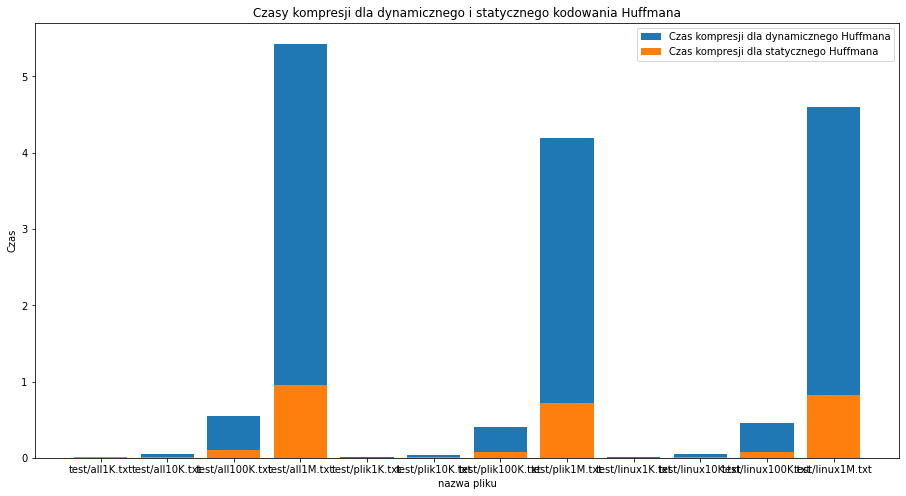

In [40]:
fig, ax = plt.subplots(figsize=(15.5, 8))

ax.bar(df1["Nazwa pliku"], df1["Czas kompresji dla dynamicznego Huffmana"], label="Czas kompresji dla dynamicznego Huffmana")
ax.bar(df1["Nazwa pliku"], df1["Czas kompresji dla statycznego Huffmana"], label="Czas kompresji dla statycznego Huffmana")

ax.set_title("Czasy kompresji dla dynamicznego i statycznego kodowania Huffmana")
ax.set_xlabel("nazwa pliku")
ax.set_ylabel("Czas")
ax.legend()

plt.show()

### Czas dekompresji

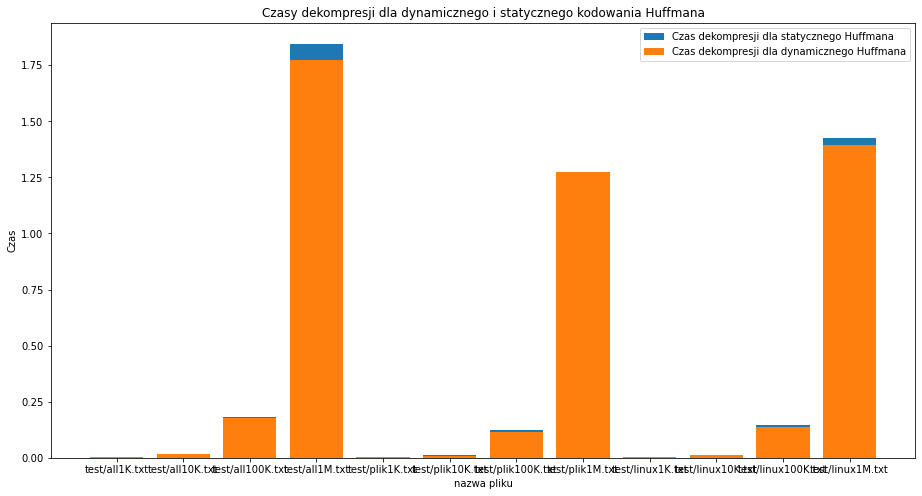

In [39]:
fig, ax = plt.subplots(figsize=(15.5, 8))

ax.bar(df1["Nazwa pliku"], df1["Czas dekompresji dla statycznego Huffmana"], label="Czas dekompresji dla statycznego Huffmana")
ax.bar(df1["Nazwa pliku"], df1["Czas dekompresji dla dynamicznego Huffmana"], label="Czas dekompresji dla dynamicznego Huffmana")

ax.set_title("Czasy dekompresji dla dynamicznego i statycznego kodowania Huffmana")
ax.set_xlabel("nazwa pliku")
ax.set_ylabel("Czas")
ax.legend()

plt.show()

# Wnioski: 

<ol> 
    <li> Dla wszystkich sprawdzanych przypadków zaimplementowane algorytmy kodowania oraz dekodowania Huffmana zadziałały poprawnie i wyniki były zgodne z oczekiwanymi. Tekst otrzymany po dekodowaniu był równy tekstowi otrzymanemu na wejściu. </li>
    <li> Patrząc na uzyskane wyniki w tabeli oraz wykresy nasuwa się wniosek, że algorytmowi "dynamicznemu" o wiele dłużej zajmuje kompresja, natomiast wypada on odrobinę lepiej dla większych plików w przypadku dekompresji. </li>
    <li>Ostatecznie wybór między statycznym a dynamicznym kodowaniem Huffmana zależy od charakterystyki danych, które chcemy kompresować. Dynamiczne kodowanie Huffmana jest użyteczne, gdy nie znamy częstości występowania symboli na wstępie i potrzebujemy przetwarzać dane na bieżąco. Statyczne kodowanie Huffmana jest dobrym wyborem, gdy dysponujemy dokładną wiedzą na temat częstości występowania symboli w zbiorze danych.  </li>
    
</ol>